In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray

from shapely.geometry import Point, Polygon, box
from tqdm.notebook import tqdm
import geopandas as gpd

import hvplot.xarray
from mapminer import miners
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
forest_labels_url = "https://drive.google.com/uc?id=1zbf3PXipN5LaYcd-2miQp148HpRPdEH3" #V1
non_forest_labels_url = 'https://drive.google.com/uc?id=1kxzyF9-0Yl0P3vg666Jc_VuPrZ8m-wes' #V1

gdf_nonForest = gpd.read_file(non_forest_labels_url)
gdf_Forest = gpd.read_file(forest_labels_url)

In [4]:
gdf_Forest = gdf_Forest.explode(index_parts=False, ignore_index=True)
gdf_nonForest = gdf_nonForest.explode(index_parts=False, ignore_index=True)

len(gdf_Forest), len(gdf_nonForest)

(18, 34)

In [5]:
miner = miners.GoogleEmbeddingMiner()

In [ ]:
Forest_embd = None
for idx, geom in enumerate(gdf_Forest.geometry):
    ds = miner.fetch(polygon=geom, daterange="2024-01-01/2025-08-19")
    mask = ds.rename({'X':'x','Y':'y'}).rio.clip([gdf_Forest.to_crs(epsg=32643).iloc[idx,:].geometry], crs=32643, drop=True)
    df = mask.isel(time=-1).to_dataframe().reset_index().drop(columns=['x', 'y', 'time', 'spatial_ref']).dropna()
    df['class'] = 1

    if Forest_embd is None:
        Forest_embd = df
    else:
        Forest_embd = pd.concat([Forest_embd, df])
    break

Forest_embd.reset_index(inplace=True)
Forest_embd.to_csv('Forest_embd_GT.csv')

[2025-08-21 14:29:41,922] [ WARNING] connectionpool.py:327 - Connection pool is full, discarding connection: earthengine.googleapis.com. Connection pool size: 10
[2025-08-21 14:29:41,937] [ WARNING] connectionpool.py:327 - Connection pool is full, discarding connection: earthengine.googleapis.com. Connection pool size: 10
[2025-08-21 14:29:41,956] [ WARNING] connectionpool.py:327 - Connection pool is full, discarding connection: earthengine.googleapis.com. Connection pool size: 10
[2025-08-21 14:29:41,959] [ WARNING] connectionpool.py:327 - Connection pool is full, discarding connection: earthengine.googleapis.com. Connection pool size: 10
[2025-08-21 14:29:41,970] [ WARNING] connectionpool.py:327 - Connection pool is full, discarding connection: earthengine.googleapis.com. Connection pool size: 10
[2025-08-21 14:29:41,975] [ WARNING] connectionpool.py:327 - Connection pool is full, discarding connection: earthengine.googleapis.com. Connection pool size: 10
[2025-08-21 14:29:42,011] [ 

In [1]:
nonForest_embd = None
for idx, geom in tqdm(enumerate(gdf_nonForest.geometry)):
    ds = miner.fetch(polygon=geom, daterange="2024-01-01/2025-08-19")
    mask = ds.rename({'X':'x','Y':'y'}).rio.clip([gdf_nonForest.to_crs(epsg=32643).iloc[idx,:].geometry], crs=32643, drop=True)
    df = mask.isel(time=-1).to_dataframe().reset_index().drop(columns=['x', 'y', 'time', 'spatial_ref']).dropna()
    df['class'] = 0

    if nonForest_embd is None:
        nonForest_embd = df
    else:
        nonForest_embd = pd.concat([nonForest_embd, df])

nonForest_embd.reset_index(inplace=True)
nonForest_embd.to_csv('nonForest_embd_GT.csv')

NameError: name 'tqdm' is not defined

In [ ]:
df_nonForest = pd.read_csv('nonForest_embd_GT.csv')
df_Forest = pd.read_csv('Forest_embd_GT.csv')

len(df_nonForest), len(df_Forest)

In [ ]:
df = pd.concat([df_nonForest, df_Forest]).reset_index(drop=True)
df = df.sample(frac=1).reset_index(drop=True)

df_label = df['class']
df_embd = df.drop(columns=['class', 'index', 'Unnamed: 0'])

# Saving

In [19]:
df.to_csv('embd.csv')

# Transforms

In [28]:
embeddings = df.iloc[:10000] # Clipping data

# Train

In [46]:
%%time
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=10)
labels_dbscan = dbscan.fit_predict(embeddings)

CPU times: user 1.14 s, sys: 8.71 ms, total: 1.15 s
Wall time: 1.55 s


In [25]:
labels

array([-1, -1, -1, ..., -1, -1, -1])

In [45]:
# np.unique(labels)


array([-1])

# Visualization

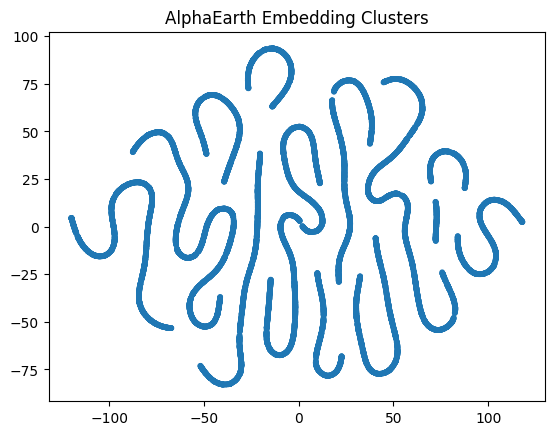

CPU times: user 2min 4s, sys: 332 ms, total: 2min 4s
Wall time: 2min 6s


In [33]:
%%time
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
emb_2d = tsne.fit_transform(embeddings)

plt.scatter(emb_2d[:,0], emb_2d[:,1], c=labels, cmap="tab10", s=10)
plt.title("AlphaEarth Embedding Clusters")
plt.show()

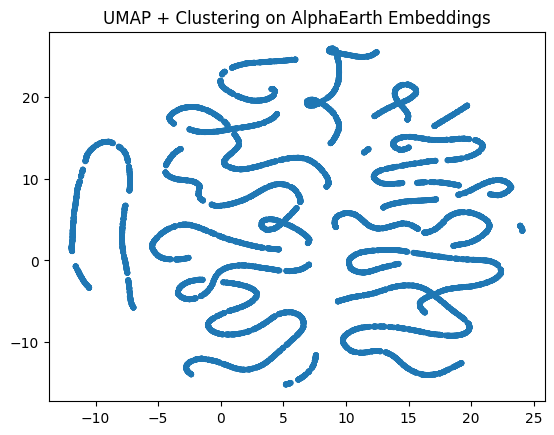

CPU times: user 2min 51s, sys: 429 ms, total: 2min 52s
Wall time: 2min 11s


In [31]:
%%time
import umap

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
emb_2d = reducer.fit_transform(embeddings)

plt.scatter(emb_2d[:,0], emb_2d[:,1], c=labels, cmap="tab10", s=10)
plt.title("UMAP + Clustering on AlphaEarth Embeddings")
plt.show()